In [1256]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math

from factor_selection import svd

In [1257]:
data = pd.read_parquet('cleaned2.parquet')
use_svd = True
non_factor_cols = {'permno', 'yyyymm', 'monthid', 'ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind', 'PRC', 'RET', 'SHROUT', 'ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12', 'date_x', 'fdate', 'ret', 'date_y', 'date'}
factor_cols = set(data.columns) - non_factor_cols

if use_svd:
    flip = ['SIR', 'RD_SALE', 'RD_P', 'range_120']
    for col in flip:
        data[col] = 1-data[col]

In [1258]:
composite_factors = [
    "mean_reversion_signal",
    # "rolling_z_score",
    "trend_factor",
    "RD_P",
    "SIR",
    "range_120",
    "range_20",
    "Accrual",
    "FCF_P",
    "xret_indsize_std120",
    "RD_SALE",
    "SIO",
    "beta_5y",
    "beta_3y",
    "betasq",
    "beta",
    "Sale_P",
    "PM_P",
    "IV_capm",
    "xret_indsize_std20",
    "FCF",
    "prcdelay1",
    "ivol",
    "mdr",
    "CASHPROD",
    "ltr36",
    "pe_ttm",
    "CAPEF",
    "CAPEI",
    "CAPES",
    "CF_P"
]
chosen = composite_factors[:10]
print(chosen)

['mean_reversion_signal', 'trend_factor', 'RD_P', 'SIR', 'range_120', 'range_20', 'Accrual', 'FCF_P', 'xret_indsize_std120', 'RD_SALE']


In [1259]:
unique_dates = sorted(data['yyyymm'].unique())
training_ratio = 4/5

split_index = int(len(unique_dates) * training_ratio)
split_date = unique_dates[split_index]
print(f"Split at yyyymm: {split_date}")

Split at yyyymm: 201501


### Obtaining Betas From Training

In [1260]:
train_data = data[data['yyyymm'] < split_date].copy()

if (use_svd):
    train_data_SVD, S, signal_weights, scaling_info = svd.svd_factor_extraction(train_data, chosen, n_factors=10)
    selected_factors = [col for col  in train_data_SVD.columns if col.startswith('SVD_')]

    train_data = pd.concat([train_data, train_data_SVD], axis=1)
else:
    selected_factors = chosen

regression_data = train_data[['permno', 'yyyymm', 'ret_f1'] + selected_factors].copy()
stock_groups = regression_data.groupby('permno')
results = []
min_observations = len(selected_factors) + 2 

In [1261]:
for permno, group in stock_groups:
    group = group.dropna(subset=['ret_f1'] + selected_factors)
    
    if len(group) >= min_observations:
        Y = group['ret_f1']
        X = group[selected_factors]
        X = sm.add_constant(X)

        try:
            model = sm.OLS(Y, X, missing='drop').fit()
            stock_result = {'permno': permno, 'alpha': model.params.get('const', np.nan)}
            for factor in selected_factors:
                stock_result[f'{factor}_beta'] = model.params.get(factor, np.nan)
            results.append(stock_result)

        except Exception as e:
            print(f"Could not run regression for permno {permno}: {e}")

stock_betas_df = pd.DataFrame(results)

In [1262]:
beta_cols = [col for col in stock_betas_df.columns if '_beta' in col]
cols_to_average = ['alpha'] + beta_cols
average_betas_and_alpha = stock_betas_df[cols_to_average].mean()

average_betas_and_alpha_df = pd.DataFrame(average_betas_and_alpha).T
average_betas_and_alpha_df.index = ['average']


In [1263]:
# flip all negative betas to positive
# for col in average_betas_and_alpha_df.columns[1:]:
#     if average_betas_and_alpha_df[col].values < 0:
#         average_betas_and_alpha_df[col] = -average_betas_and_alpha_df[col]

print(average_betas_and_alpha_df)
if not use_svd:
    average_betas_and_alpha_df['SIR_beta'] = -average_betas_and_alpha_df['SIR_beta']
    average_betas_and_alpha_df['RD_SALE_beta'] = -average_betas_and_alpha_df['RD_SALE_beta']
    average_betas_and_alpha_df['RD_P_beta'] = -average_betas_and_alpha_df['RD_P_beta']
    average_betas_and_alpha_df['range_120_beta'] = -average_betas_and_alpha_df['range_120_beta']

            alpha  SVD_Factor_1_beta  SVD_Factor_2_beta  SVD_Factor_3_beta  \
average  0.024557           0.031728           0.106128           0.020459   

         SVD_Factor_4_beta  SVD_Factor_5_beta  SVD_Factor_6_beta  \
average          -0.004283           0.002011           0.008918   

         SVD_Factor_7_beta  SVD_Factor_8_beta  SVD_Factor_9_beta  \
average          -0.000251           0.010513           0.137796   

         SVD_Factor_10_beta  
average           -0.004051  


### Backtesting Linear Model
r̃_{i,t+1} = â₀ + b̂₁F1_{i,t} + b̂₂F2_{i,t} + ... + b̂_K Fk_{i,t} for stocks i at t, then calculating decile returns

In [1264]:
backtest_data = data[data['yyyymm'] >= split_date].copy()
backtest_data['monthid'] = backtest_data['monthid'] - 420

if (use_svd):
    backtest_data_SVD = svd.apply_svd_factors(backtest_data, chosen, signal_weights, scaling_info, n_factors=10)
    backtest_data = pd.concat([backtest_data, backtest_data_SVD], axis=1)

In [1265]:
avg_alpha = average_betas_and_alpha_df['alpha']['average']
avg_betas = average_betas_and_alpha_df[[col for col in average_betas_and_alpha_df.columns if '_beta' in col]].iloc[0]
avg_betas.index = [col.replace('_beta', '') for col in avg_betas.index]

factors_for_prediction = [factor for factor in selected_factors if factor in backtest_data.columns]
backtest_data['predicted_ret'] = avg_alpha

for factor in factors_for_prediction:
    if factor in avg_betas:
        backtest_data['predicted_ret'] += backtest_data[factor] * avg_betas[factor]

In [1266]:
portfolio_returns = []
monthly_groups = backtest_data.groupby('yyyymm')

for month, group in monthly_groups:
    group = group.dropna(subset=['predicted_ret', 'ret_f1'])

    if len(group) < 10:
        continue
    try:
        group_copy = group.copy()
        group_copy.loc[:, 'decile'] = pd.qcut(group_copy['predicted_ret'], 10, labels=False, duplicates='drop') + 1
        group = group_copy 
    except ValueError as e:
        print(f"Could not form deciles for month {month} due to: {e}. Skipping.")
        continue

    if 1 not in group['decile'].values or 10 not in group['decile'].values:
        continue

    long_portfolio_ret = group[group['decile'] == 10]['ret_f1'].mean()
    short_portfolio_ret = group[group['decile'] == 1]['ret_f1'].mean()

    long_stocks = group[group['decile'] == 10]['permno'].unique()
    short_stocks = group[group['decile'] == 1]['permno'].unique()

    if pd.isna(long_portfolio_ret) or pd.isna(short_portfolio_ret):
        continue

    hedge_return = long_portfolio_ret - short_portfolio_ret
    portfolio_returns.append(
        {'yyyymm': month, 
         'hedge_return': hedge_return, 
         'long_stocks': long_stocks, 
         'short_stocks': short_stocks}
    )

hedge_portfolio_df = pd.DataFrame(portfolio_returns)
hedge_portfolio_df['yyyymm'] = pd.to_datetime(hedge_portfolio_df['yyyymm'], format='%Y%m')
hedge_portfolio_df = hedge_portfolio_df.set_index('yyyymm')
# avoid lookahead bias by shifting the index by one month
# make first month returns 0
hedge_portfolio_df['hedge_return'] = hedge_portfolio_df['hedge_return'].shift(1)
hedge_portfolio_df.loc[hedge_portfolio_df.index[0], 'hedge_return'] = 0.0

In [1267]:
number_of_stocks = hedge_portfolio_df['long_stocks'].apply(len) + hedge_portfolio_df['short_stocks'].apply(len)
average_number_of_stocks = number_of_stocks.mean()
print(f"Average number of stocks in hedge portfolio: {average_number_of_stocks:.2f}")

Average number of stocks in hedge portfolio: 56.00


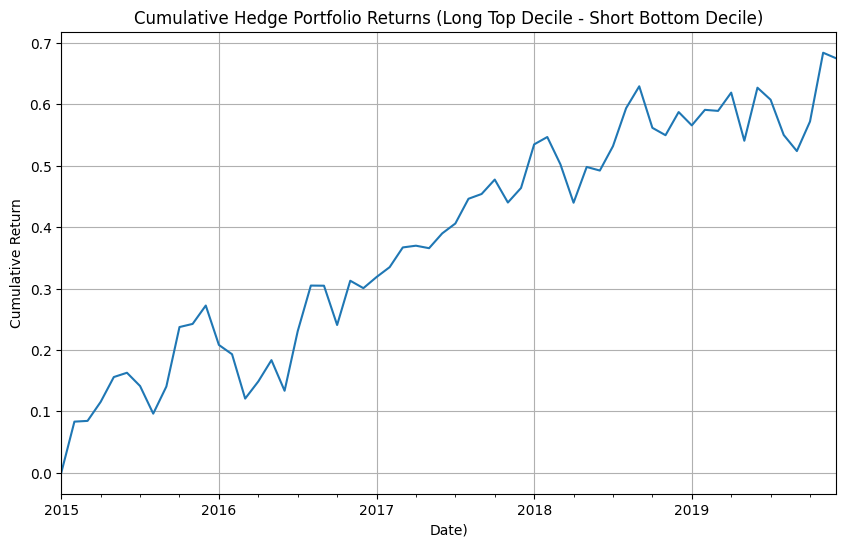

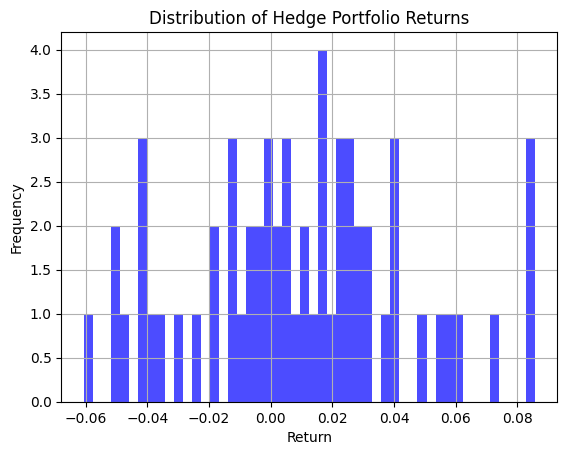

In [1268]:
hedge_portfolio_df['cumulative_return'] = (1 + hedge_portfolio_df['hedge_return']).cumprod() - 1
plt.figure(figsize=(10, 6))
hedge_portfolio_df['cumulative_return'].plot(title='Cumulative Hedge Portfolio Returns (Long Top Decile - Short Bottom Decile)')
plt.xlabel('Date)')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

hedge_portfolio_df['hedge_return'].hist(bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Hedge Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Analysis 
(1) Raw return 
(2)Sharpe ratio
(3) CAPM alpha
(4) Fama-French 3-Factor alpha
(5) Information Ratio
using 3-factor model

In [1269]:
ff_factors = pd.read_sas('ff_factors_monthly.sas7bdat')
ff_factors['monthid'] = ff_factors['DATEFF'].dt.strftime('%Y%m').astype(int)
ff_factors.set_index('monthid', inplace=True)

In [1270]:
hedge_portfolio_df_copy = hedge_portfolio_df.copy()
hedge_portfolio_df_copy['monthid'] = hedge_portfolio_df_copy.index.strftime('%Y%m').astype(int)

hedge_portfolio_df_copy = pd.merge(hedge_portfolio_df_copy, ff_factors, on='monthid', how='left')
hedge_portfolio_df_copy.set_index('monthid', inplace=True)

# Calculate excess returns
hedge_portfolio_df_copy['excess_return'] = hedge_portfolio_df_copy['hedge_return'] - hedge_portfolio_df_copy['RF']

analytics = {}

analytics['raw_return'] = hedge_portfolio_df_copy['hedge_return'].mean() * 12
analytics['sharpe_ratio'] = (hedge_portfolio_df_copy['excess_return'].mean() * 12) / (hedge_portfolio_df_copy['excess_return'].std() * np.sqrt(12))

# CAPM
X = sm.add_constant(hedge_portfolio_df_copy['MKTRF'])
capm_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X).fit()
analytics['capm_alpha'] = capm_model.params['const'] * 12

# FF3
X_ff3 = sm.add_constant(hedge_portfolio_df_copy[['MKTRF', 'SMB', 'HML']])
ff3_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X_ff3).fit()
analytics['ff3_alpha'] = ff3_model.params['const'] * 12

# Information Ratio
hedge_portfolio_df_copy['benchmark_return'] = hedge_portfolio_df_copy['MKTRF'] + hedge_portfolio_df_copy['RF']
analytics['information_ratio'] = ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).mean() * 12) / ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).std() * np.sqrt(12))

print("Analytics:")
for key, value in analytics.items():
    print(f"{key}: {value:.4f}")

Analytics:
raw_return: 0.1106
sharpe_ratio: 0.8348
capm_alpha: 0.0536
ff3_alpha: 0.0508
information_ratio: -0.1229
